# Imports

In [1]:
import os
import shutil
import copy
import matplotlib.pyplot as plt
import pandas
from molgroups.support import molstat
from molgroups.infotheory import entropy

# always use the same testdata
shutil.copyfile('./bu/sim0.dat', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/sim1.dat', os.getcwd()+'/sim1.dat')

'C:\\Users\\Frank Heinrich\\PycharmProjects\\molgroups\\examples\\information_theory\\experimental_optimization\\SANS\\SphereSilica_TwoDatasets_SolventSLD_GPCam_LM/sim1.dat'

# Variables for example fit and optimization

In [2]:
# Run Optimization or only example fit and data simulation
RunFit = False
RunOptimization=True

# Folders and type of analysis
store = "T"
setupdir = os.getcwd()
runfile = "run"
fitsource = "SASView"

burn = 5000
steps = 100

# Optimization-specific paramters

# enforced qmin and qmax, even if detector would cover larger q-range
# alternatively: take enforced q-range from first provided data file (index 0)
# set total counting time for the entire experiment (in s), or None
# number of gpcam iterations, if gpcam is used, init dataset size to 20,
qmin = 0.001
qmax = 0.8
qrangefromfile = False
t_total = None
optimizer = 'gpcam' # can be 'gpcam' or 'grid'
fitter = 'LM'  # fit driver for optimization either 'MCMC' or 'LM'
steps_LM = 100
remove_fit_dir = False

# relevant only for 'gpcam' optimizer
gpcam_iterations = 200
gpcam_init_dataset_size = 20  # usually 20
gpcam_step = 4                # at least 2 to make use of local and global optimization
# Acquisition Functions. Use "variance" for pure exploration, 'maximum' to zero in on an already identified information gain maximum, 'ucb' for an exploration-exploitation balance, and 'shannon_ig_vec' for a maximization in information gain.
acq_func='variance'

# relevant only for 'grid' optimizer
convergence = 2.0
miniter = 3
bcalcsymmetric = True

# isotropic scattering background
# user-defined linear relationship between a SLD of the bulk solvent and the differential macroscopic scattering crosssection of the buffer
cross_section_background = {'slope':-0.1626, 'y_intercept': 0.7980}
mode = 'SANS_linear'

# Prepareto keep plots for individual iterations and make fine enough steps between record keeping. Useful for constructing a movie.
# If not needed, set keep_plots to False, do not show support points, and set gpcam steps to None
keep_plots = True
show_support_points = True
upper_info_plotlevel = None
plotlimits_filename = ""

# particular entropy setup
bClusterMode = False
bFetchMode = False
time = 2
calcsingle = False

# setup batchscript for SLURM (if used)
script = ['#!/bin/bash\n',
          '#SBATCH --job-name=entro {mcmc_iteration}\n',
          '#SBATCH -A mc4s9np\n', '#SBATCH -p RM\n',
          '#SBATCH -t 0' + str(time) + ':00:00\n',
          '#SBATCH -N 4\n', '#SBATCH --ntasks-per-node 28\n',
          '\n',
          'set +x\n',
          'cd $SLURM_SUBMIT_DIR\n',
          '\n',
          'module load python/2.7.11_gcc\n',
          'export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n',
          '\n',
          'mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time='
          + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn)
          + ' --steps=' + str(steps) + '\n'
          ]
# script.append('cd '+dirname+'\n')

# Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%writefile run.py

from bumps.names import *
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
data1 = load_data('sim1.dat')

#setattr(data, 'qmin', 0.01)
#setattr(data, 'qmax', 10.0)

# DEFINE THE MODEL
kernel = load_model('sphere')

pars0 = dict(scale=0.002, background=0.15, sld=3.0, sld_solvent=2.4, radius=60.0, radius_pd=0.3)
pars1 = dict(scale=0.002, background=0.15, sld=3.0, sld_solvent=3.4, radius=60.0, radius_pd=0.3)

model0 = Model(kernel, **pars0)
model1 = Model(kernel, **pars1)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
background0 = Parameter(name='background0', value=0.4).range(0.01, 0.8)
background1 = Parameter(name='background1', value=0.4).range(0.01, 0.8)
sld_solvent0 = Parameter(name='sld_solvent0', value=2.0).range(-0.56, 6.4)
sld_solvent1 = Parameter(name='sld_solvent1', value=2.0).range(-0.56, 6.4)

model0.scale.range(0.001, 0.006)
model0.background = background0
model0.sld.range(2, 4)
model0.sld_solvent = sld_solvent0
model0.radius.range(40., 80.)
model0.radius_pd.range(0.3, 0.5)

model1.scale = model0.scale
model1.background = background1
model1.sld = model0.sld
model1.sld_solvent = sld_solvent1
model1.radius = model0.radius
model1.radius_pd=model0.radius_pd

M0 = Experiment(data=data0, model=model0)
M1 = Experiment(data=data1, model=model1)

problem = MultiFitProblem([M0, M1])

Overwriting run.py


## 2. Run Example Fit

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    # remove store directory if it already exists, since we do not want to reload here
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

fitobj.fnRestoreFit()

## Test Data Simulation
1. Show Best-fit parameters from above fit

In [5]:
df = pandas.read_csv(os.path.join(setupdir, store, runfile+'.par'), sep='\s+', header=None, names=['Parameter', 'Fit Value'])
df

,Parameter,Fit Value
0,background0,0.159005
1,radius,59.964179
2,radius_pd,0.499092
3,scale,0.001414
4,sld,2.452268
5,sld_solvent0,3.648546
6,background1,0.295493
7,sld_solvent1,2.704622


2. Define simulation model parameters. They are written out to simpar.dat. Please change to desired values or copy from dataframe above.

In [6]:
%%writefile simpar.dat
background0 0.159031
background1 0.295424
sld_solvent0 3.090
sld_solvent1 0.988
scale 0.0007
sld  1.355
radius  49.67
radius_pd 0.674

Overwriting simpar.dat


3. Define Instrument configurations. Each dataset can have its own instrument configuration. In the example below, a single configuration is assigned to all datasets. The configuration is made of three settings with different sample-detector distances.

In [7]:
# buffer is not subtracted but treated as a fitting parameter
sb = 0.0

configuration_dataset1 = [{'lambda': 6.0,
                            "sample_detector_distance": 100,
                            'source_sample_distance': 387.6,
                            'source_aperture_radius':5.08*0.5,
                            'sample_aperture_radius':1.27*0.5,
                            "beamstop_diameter": 10.16,
                            "neutron_flux": 9e5,
                            'time': 1200,
                            'beam_center_x': 25,
                            "dlambda_lambda":0.136,
                            "differential_cross_section_buffer": sb,
                            "cuvette_thickness": 0.1},
                          {'lambda': 6.0,
                           "sample_detector_distance": 400,
                           'source_sample_distance': 850.05,
                           'source_aperture_radius':5.08*0.5,
                           'sample_aperture_radius':1.27*0.5,
                           "beamstop_diameter": 10.16,
                           "neutron_flux": 2e5,
                           'time': 2400,
                           "dlambda_lambda":0.136,
                           "differential_cross_section_buffer": sb,
                           "cuvette_thickness": 0.1},
                         {'lambda': 6.0,
                          "sample_detector_distance": 1300,
                          'source_sample_distance': 1467,
                          'source_aperture_radius':5.08*0.5,
                          'sample_aperture_radius':1.27*0.5,
                          "dlambda_lambda":0.136,
                          "beamstop_diameter": 7.62,
                          "neutron_flux": 8e4,
                          'time': 3600,
                          "differential_cross_section_buffer": sb,
                          "cuvette_thickness": 0.1}]

configuration = [configuration_dataset1, copy.deepcopy(configuration_dataset1)]

4. Visually check configuration.

In [8]:
df = pandas.DataFrame.from_dict(configuration_dataset1)
df

,lambda,sample_detector_distance,source_sample_distance,source_aperture_radius,sample_aperture_radius,beamstop_diameter,neutron_flux,time,beam_center_x,dlambda_lambda,differential_cross_section_buffer,cuvette_thickness
0,6.0,100,387.60,2.54,0.635,10.16,900000.0,1200,25.0,0.136,0.0,0.1
1,6.0,400,850.05,2.54,0.635,10.16,200000.0,2400,NaN,0.136,0.0,0.1
2,6.0,1300,1467.00,2.54,0.635,7.62,80000.0,3600,NaN,0.136,0.0,0.1


5. Simulate data.

In [9]:
fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=0.001, qmax=0.8, t_total=None)

            par      value
0   background0   0.159031
1   background1   0.295424
2  sld_solvent0   3.090000
3  sld_solvent1   0.988000
4         scale   0.000700
5           sld   1.355000
6        radius  49.670000
7     radius_pd   0.674000
[[{'lambda': 6.0, 'sample_detector_distance': 100, 'source_sample_distance': 387.6, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 900000.0, 'time': 1200, 'beam_center_x': 25, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.0, 'cuvette_thickness': 0.1}, {'lambda': 6.0, 'sample_detector_distance': 400, 'source_sample_distance': 850.05, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 200000.0, 'time': 2400, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.0, 'cuvette_thickness': 0.1}, {'lambda': 6.0, 'sample_detector_distance': 1300, 'source_sample_distance': 1467, 'source_aperture_radius': 2.54, '

C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


### Compare original and simulated data.
1. Compare Data

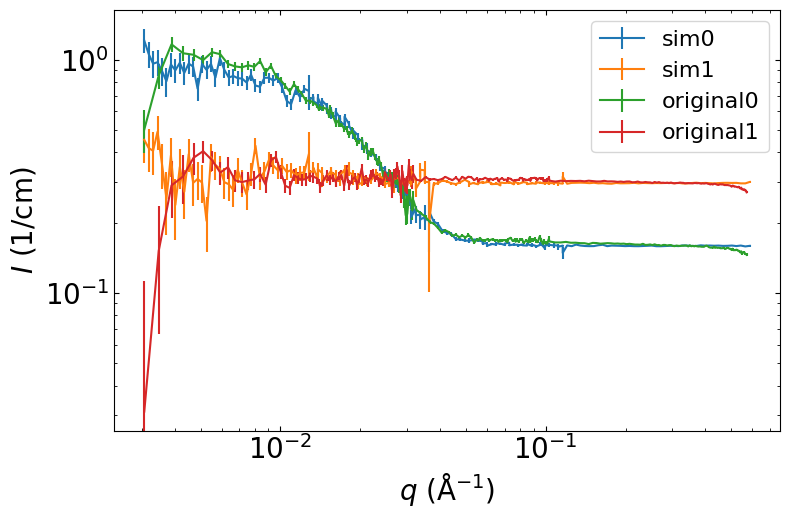

In [10]:
import pandas

fig, ax = plt.subplots()

original0 = pandas.read_csv('bu/sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata0 = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
original1 = pandas.read_csv('bu/sim1.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata1 = pandas.read_csv('sim1.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.errorbar(simdata0['Q'], simdata0['I'], simdata0['dI'], label="sim0")
ax.errorbar(simdata1['Q'], simdata1['I'], simdata1['dI'], label="sim1")
ax.errorbar(original0['Q'], original0['I'], original0['dI'], label="original0")
ax.errorbar(original1['Q'], original1['I'], original1['dI'], label="original1")

ax.legend(fontsize=16)
ax.set_ylabel("$I$ (1/cm)", fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=20)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=20)
ax.figure.set_size_inches(8, 8*0.66)
#ax.set_ylim(1e-2, 1e8)
plt.tight_layout()
plt.savefig(store + "/intensity_comparison.png", facecolor="white")
plt.show()

2. Compare Uncertainties

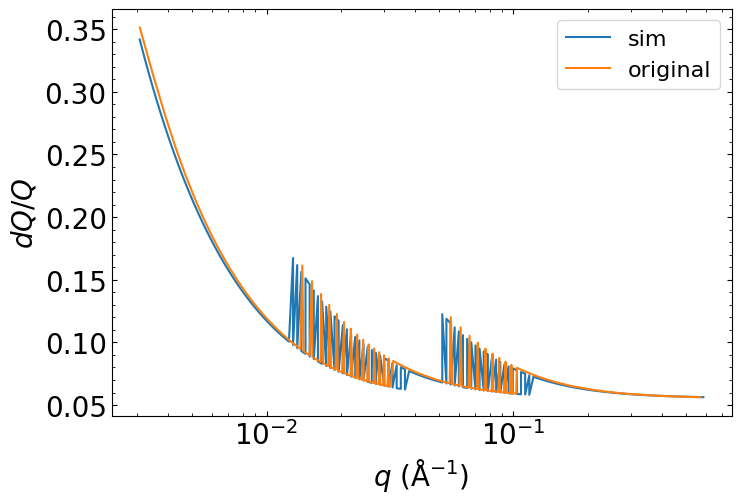

In [11]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
ax.plot(simdata['Q'], (simdata['dQ']/simdata['Q']), label="sim")
ax.plot(original['Q'], (original['dQ']/original['Q']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("$dQ/Q$", fontsize=20)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=20)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=20)
ax.figure.set_size_inches(8, 8*0.66)
#ax.set_ylim(0, 0.01)
plt.savefig(store + "/resolution_comparison.png", facecolor="white")
plt.show()

3. Compare resolutions

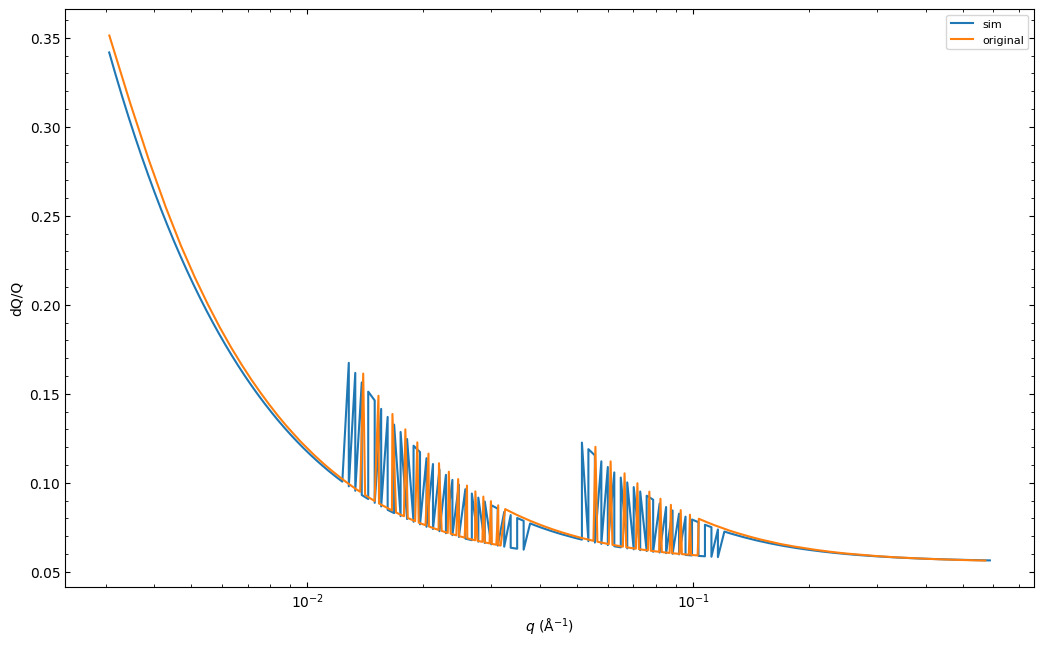

In [12]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
ax.plot(simdata['Q'], (simdata['dQ']/simdata['Q']), label="sim")
ax.plot(original['Q'], (original['dQ']/original['Q']), label="original")

ax.legend(fontsize=8)
ax.set_ylabel("dQ/Q", fontsize=10)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
#ax.set_ylim(0, 0.01)
plt.savefig(store + "/resolution_comparison.png", facecolor="white")
plt.show()


# Experimental Optimization

1. Create a data file (entropypar.dat) that sets the values and fit ranges for model parameters, values for configuration parameters, and designates paramters to optimize.

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries.
* Configuration parameters are given by a preceeding n x y, where x is the data set it applies to and y the configuration number. Specifying x,y = '*' makes this parameter apply to all configurations.
* Any numbers x y following a fit parameter indicates that this paramter is used for this particular dataset/configuration to determine the background (incoherent crosssection). This typically applies to SLDs. The 'mode' argument for entropy.Entropy() then determines whether this is to be interpreted as an aqueous solvent or other. Sometimes, instead of subtracting an incoherent crosssection from the data, a background parameter is retained in the model. If any of the parameters is asigned an x = bi, this background will be se to the incoherent (isotropic) crosssection of the ith data set, instead of applying this value to the configuration. Fit boundaries for such backgrounds must be large enough to encompass all possible outcomes. They will not be updated dynamically.
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step).
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* If an instrumental parameter is specified for one data set, the instrumental parameter needs to be specified for all other datasets, as well.
* Data filenames are currently limited to sim.dat for a single file fit, or simx.dat, x = 0 ... n, for fits with multiple data sets

In [13]:
text = [
        'i b0 * background0 0.509283 0.0 2.0',
        'i b1 * background1 0.295525 0.0 2.0',
        'i 0 * sld_solvent0 2.0 1.95 2.05 1.5 4.5 0.5',
        'i 1 * sld_solvent1 2.0 1.95 2.05 1.5 4.5 0.5',
        'i _ _ scale 0.0013 0.0011 0.0015',
        'd _ _ sld  3.1 1.0 4.0',
        'd _ _ radius  65 40 90',
        'd _ _ radius_pd  0.3 0.1 0.5',
        'n * * lambda 6.00',
        'n * * differential_cross_section_buffer 0.0',
        'n * 0 sample_detector_distance 100',
        'n * 1 sample_detector_distance 400',
        'n * 2 sample_detector_distance 1300',
        'n * 0 source_sample_distance 387.6',
        'n * 1 source_sample_distance 850.05',
        'n * 2 source_sample_distance 1467',
        'n * 0 neutron_flux 9e5',
        'n * 1 neutron_flux 2e5',
        'n * 2 neutron_flux 8e4',
        'n * * source_aperture_radius 2.54',
        'n * * sample_aperture_radius 0.635',
        'n * * dlambda_lambda 0.136',
        'n * 0 beamstop_diameter 10.16',
        'n * 1 beamstop_diameter 10.16',
        'n * 2 beamstop_diameter 7.62',
        'n * 0 time 1200',
        'n * 1 time 2400',
        'n * 2 time 3600',
        'n * 0 beam_center_x 25.',
        'n * * cuvette_thickness 0.1'
        ]

f=open('entropypar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

header_names = ['type', 'dataset', 'config.', 'parameter', 'value', 'l_fit', 'u_fit', 'l_opt', 'u_opt', 'step_opt']
df = pandas.read_csv('entropypar.dat', sep='\s+', header=None, names=header_names, skip_blank_lines=True, comment='#')
df

,type,dataset,config.,parameter,value,l_fit,u_fit,l_opt,u_opt,step_opt
0,i,b0,*,background0,0.509283,0.0000,2.0000,NaN,NaN,NaN
1,i,b1,*,background1,0.295525,0.0000,2.0000,NaN,NaN,NaN
2,i,0,*,sld_solvent0,2.000000,1.9500,2.0500,1.5,4.5,0.5
3,i,1,*,sld_solvent1,2.000000,1.9500,2.0500,1.5,4.5,0.5
4,i,_,_,scale,0.001300,0.0011,0.0015,NaN,NaN,NaN
5,d,_,_,sld,3.100000,1.0000,4.0000,NaN,NaN,NaN
6,d,_,_,radius,65.000000,40.0000,90.0000,NaN,NaN,NaN
7,d,_,_,radius_pd,0.300000,0.1000,0.5000,NaN,NaN,NaN
8,n,*,*,lambda,6.000000,NaN,NaN,NaN,NaN,NaN
9,n,*,*,differential_cross_section_buffer,0.000000,NaN,NaN,NaN,NaN,NaN


2. Run Optimization

In [14]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn,
    mcmcsteps=steps_LM,
    convergence=convergence,
    miniter=miniter,
    mode=mode,
    background_rule = cross_section_background,
    bClusterMode=bClusterMode,
    bFetchMode=bFetchMode,
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel,
    plotlimits_filename=plotlimits_filename,
    slurmscript=script,
    configuration = configuration,
    keep_plots = keep_plots,
    optimizer = optimizer,
    show_support_points = show_support_points,
    qmin=qmin,
    qmax=qmax,
    qrangefromfile=qrangefromfile,
    t_total=t_total,
    gpcam_iterations=gpcam_iterations,
    jupyter_clear_output=True,
    gpcam_init_dataset_size=gpcam_init_dataset_size,
    gpcam_step=gpcam_step,
    acq_func=acq_func,
    fitter = fitter,
    remove_fit_dir=remove_fit_dir
)

if RunOptimization:
    entr.run_optimization()

                                  par          value
0                         background0       0.092486
1                         background1       0.068319
2                        sld_solvent0       4.338957
3                        sld_solvent1       4.487586
4                               scale       0.001300
5                                 sld       3.100000
6                              radius      65.000000
7                           radius_pd       0.300000
8                              lambda       6.000000
9   differential_cross_section_buffer       0.000000
10           sample_detector_distance     100.000000
11           sample_detector_distance     400.000000
12           sample_detector_distance    1300.000000
13             source_sample_distance     387.600000
14             source_sample_distance     850.050000
15             source_sample_distance    1467.000000
16                       neutron_flux  900000.000000
17                       neutron_flux  200000.

C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


-- Model 0 sim0.dat
.background = background0 = 0.0924268 in [0,2]
.radius = 65.0821 in [40,90]
.radius_pd = 0.295733 in [0.1,0.5]
.radius_pd_n = 35
.radius_pd_nsigma = 3
.scale = 0.00127702 in [0.0011,0.0015]
.sld = 3.08661 in [1,4]
.sld_M0 = 0
.sld_mphi = 0
.sld_mtheta = 0
.sld_solvent = sld_solvent0 = 4.33741 in [4.28896,4.38896]
.sld_solvent_M0 = 0
.sld_solvent_mphi = 0
.sld_solvent_mtheta = 0
.up_angle = 0
.up_frac_f = 0
.up_frac_i = 0
.up_phi = 0

[chisq=0.836(38), nllf=78.1273]
-- Model 1 sim1.dat
.background = background1 = 0.0684034 in [0,2]
.radius = 65.0821 in [40,90]
.radius_pd = 0.295733 in [0.1,0.5]
.radius_pd_n = 35
.radius_pd_nsigma = 3
.scale = 0.00127702 in [0.0011,0.0015]
.sld = 3.08661 in [1,4]
.sld_M0 = 0
.sld_mphi = 0
.sld_mtheta = 0
.sld_solvent = sld_solvent1 = 4.49176 in [4.43759,4.53759]
.sld_solvent_M0 = 0
.sld_solvent_mphi = 0
.sld_solvent_mtheta = 0
.up_angle = 0
.up_frac_f = 0
.up_frac_i = 0
.up_phi = 0

[chisq=0.863(38), nllf=80.7226]
[overall chisq=0.868

4. Show Plots

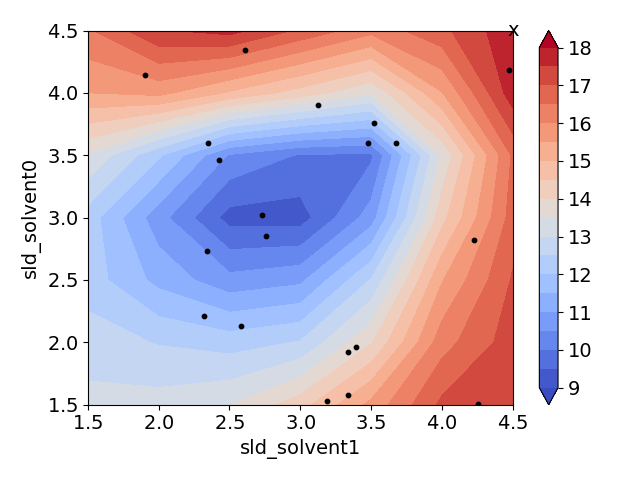

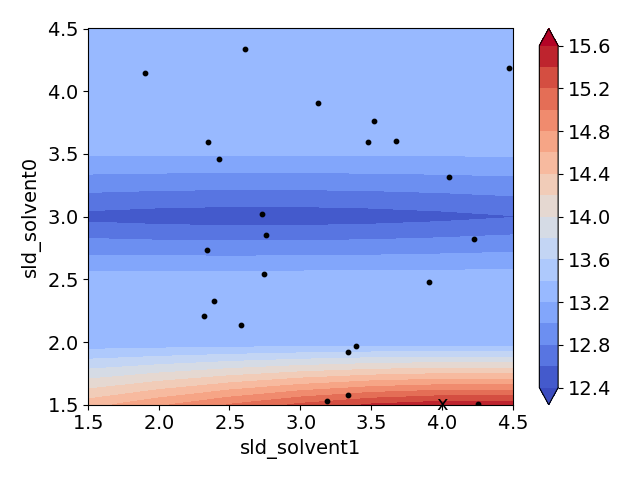

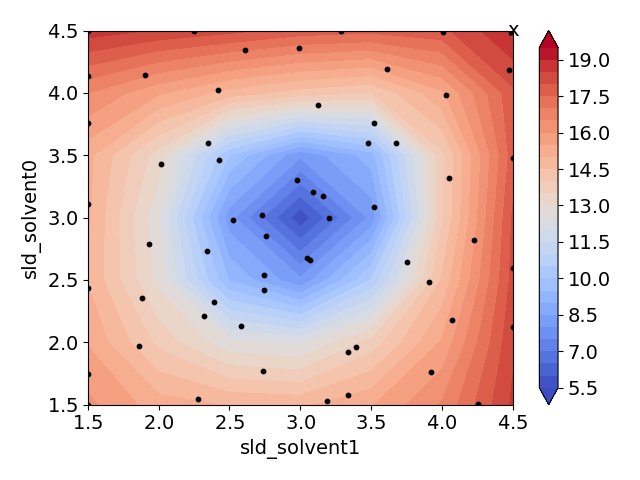

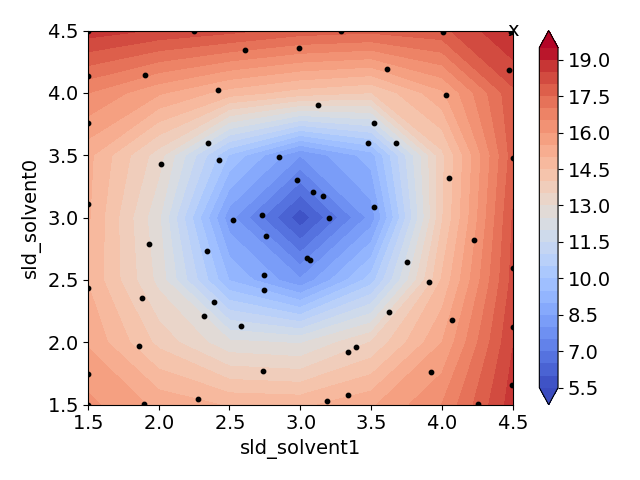

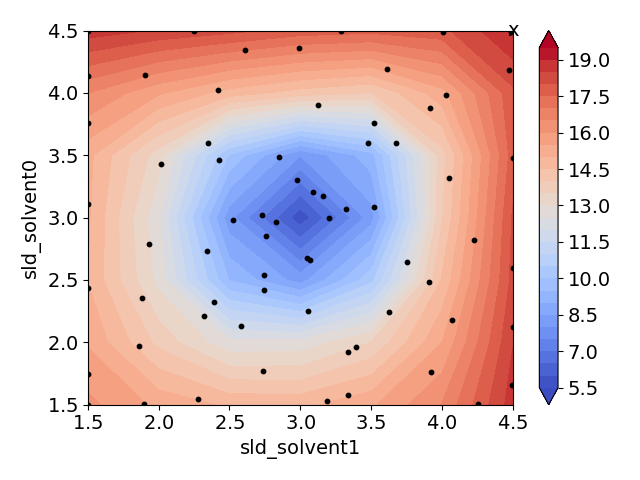

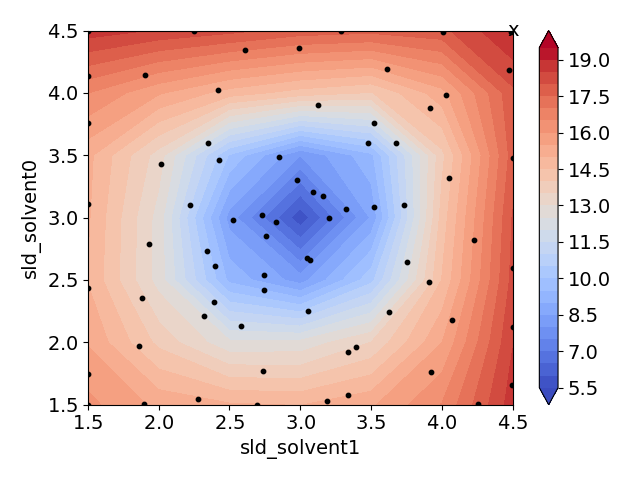

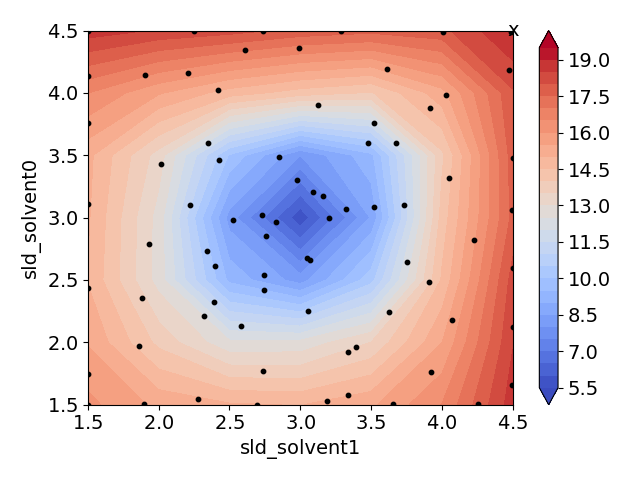

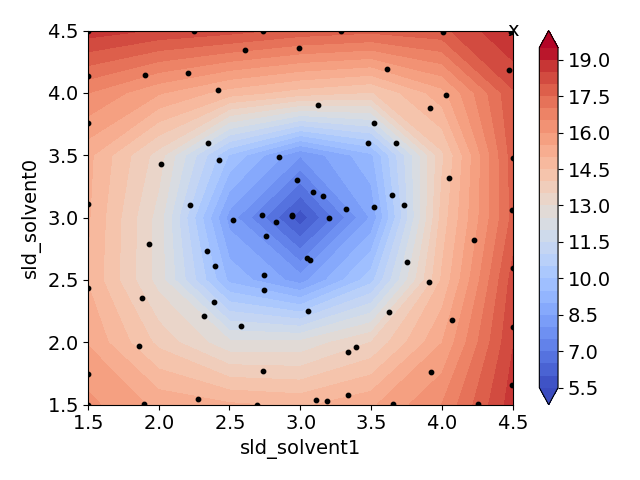

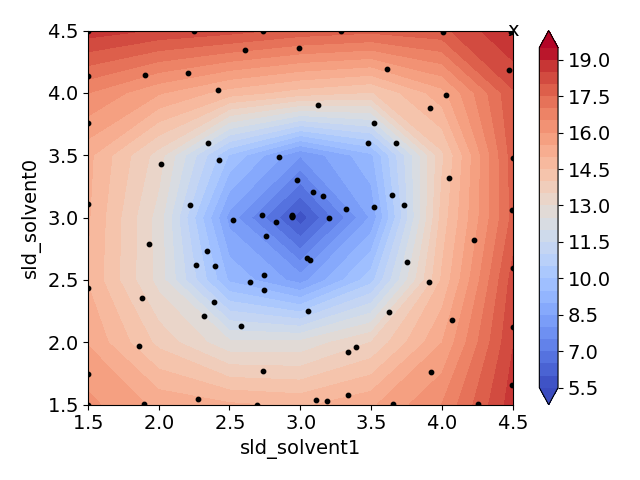

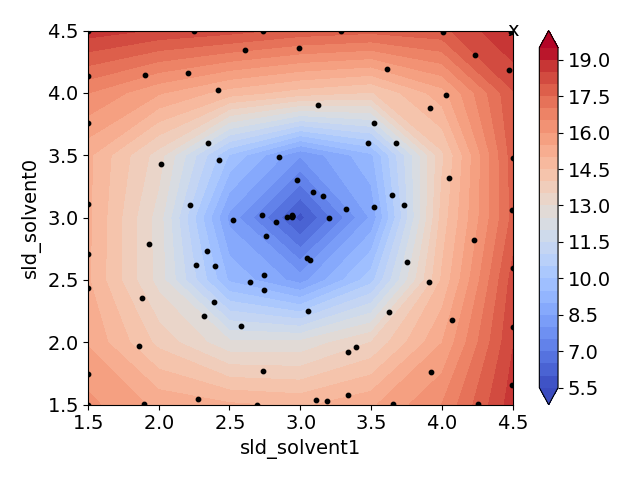

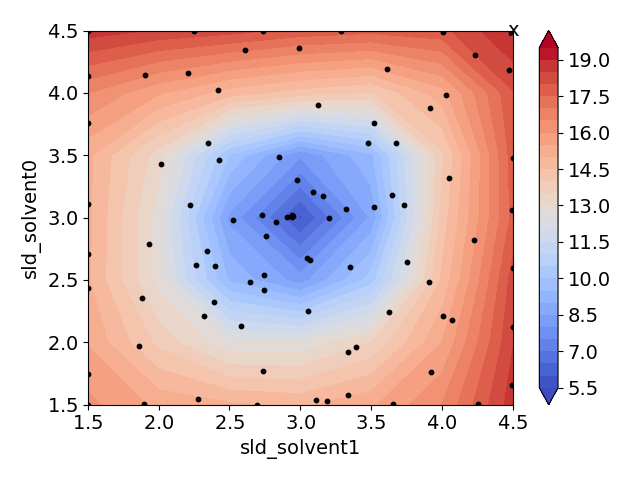

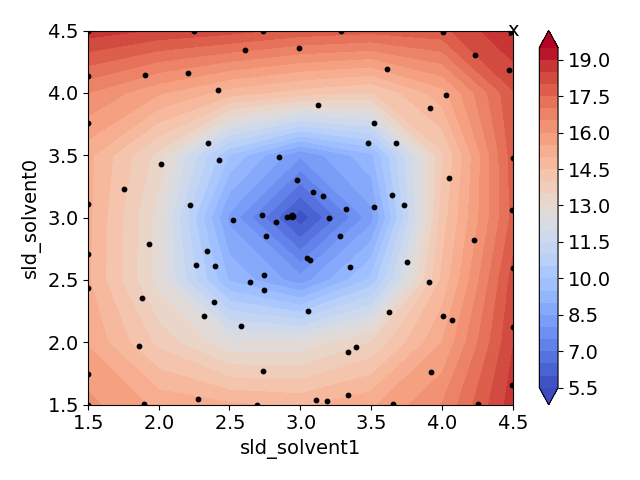

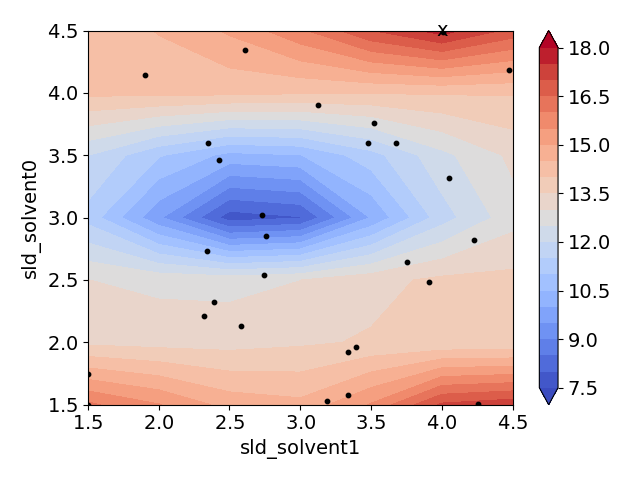

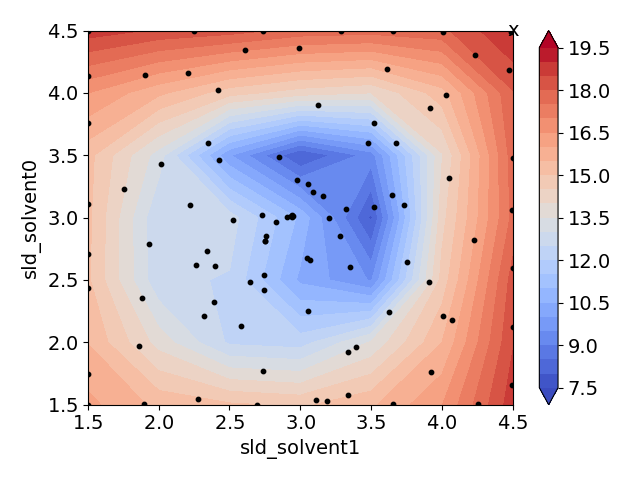

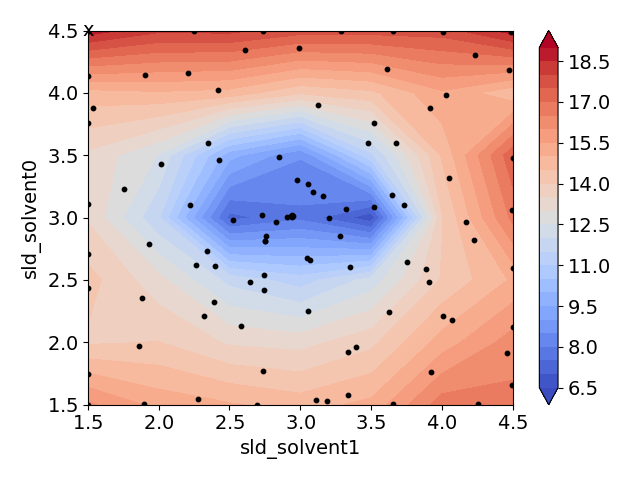

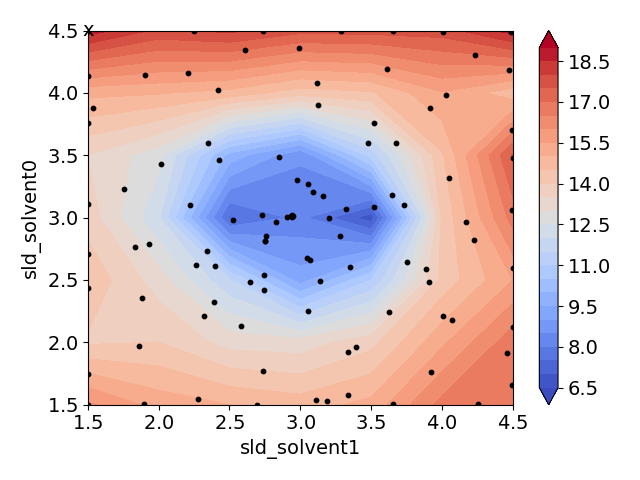

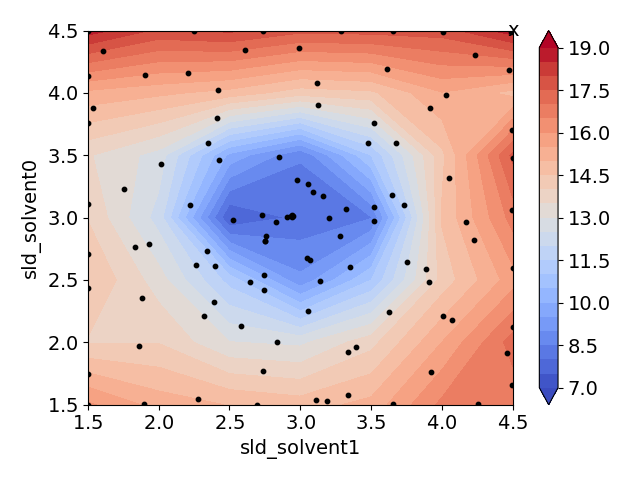

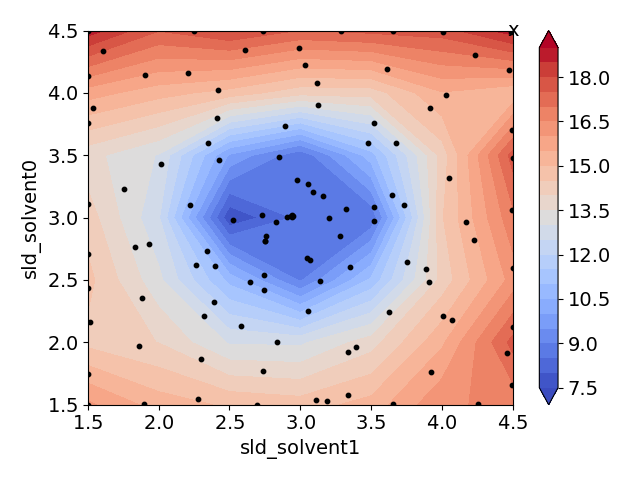

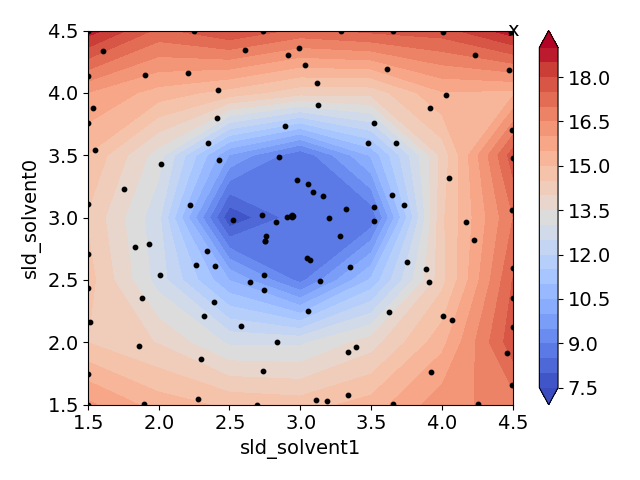

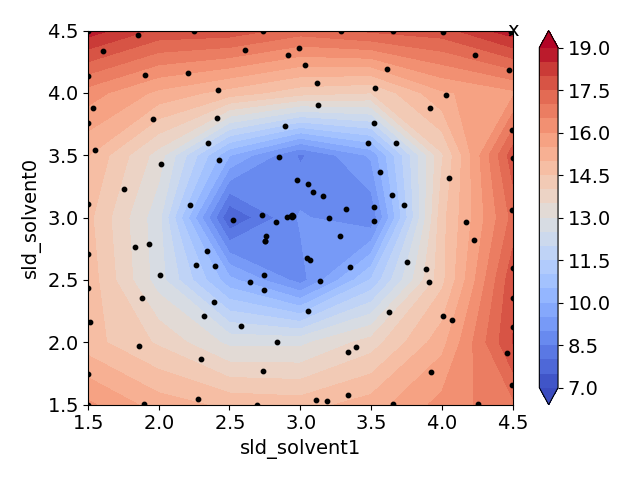

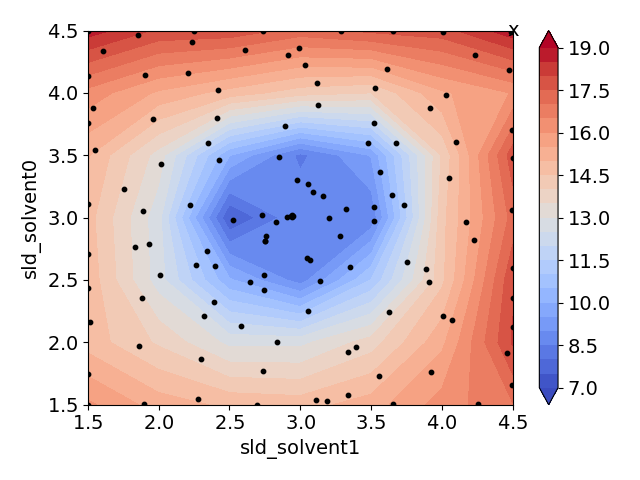

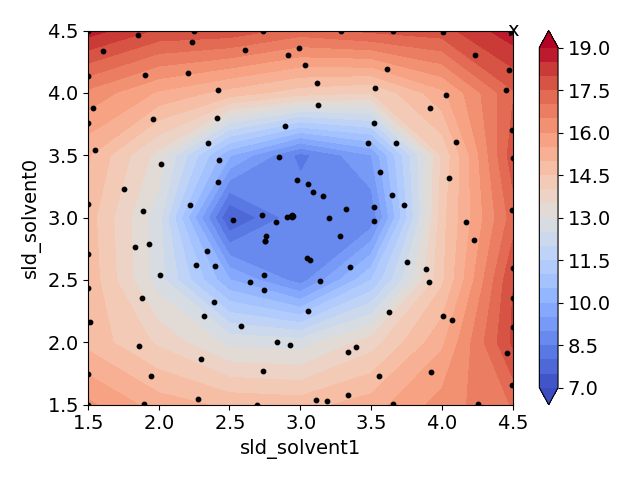

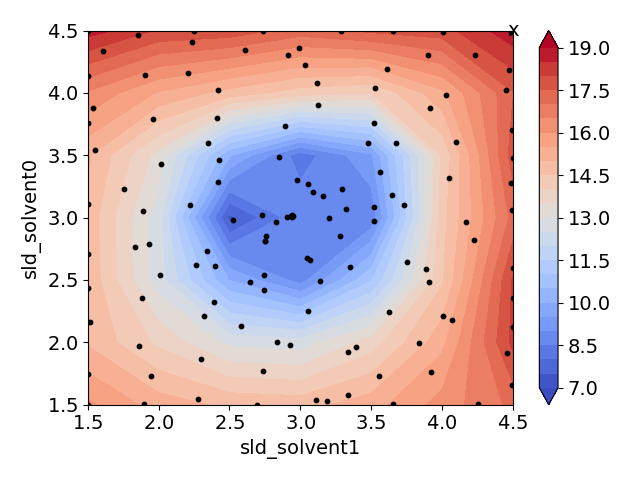

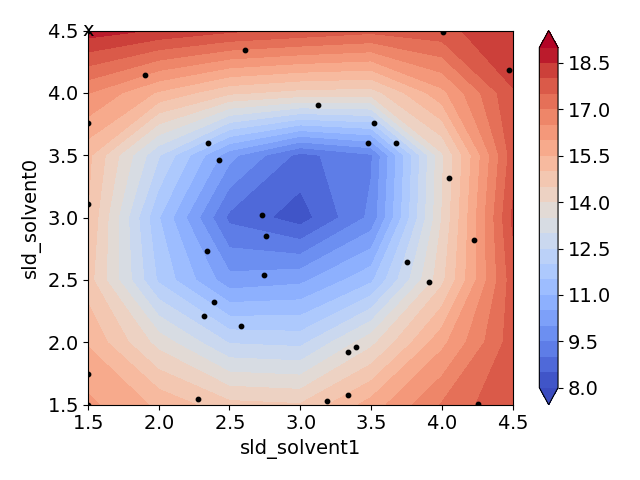

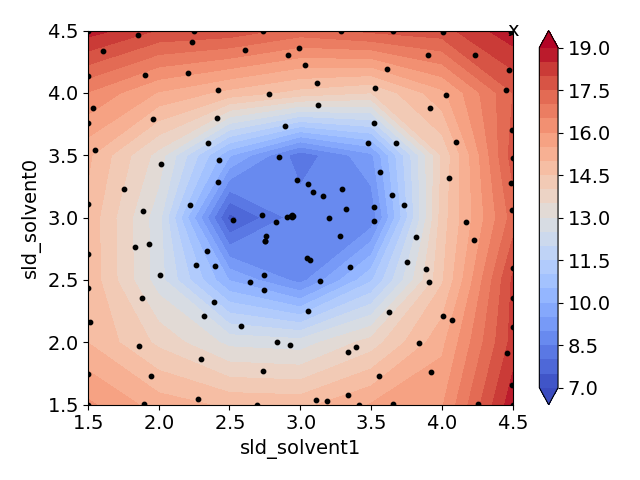

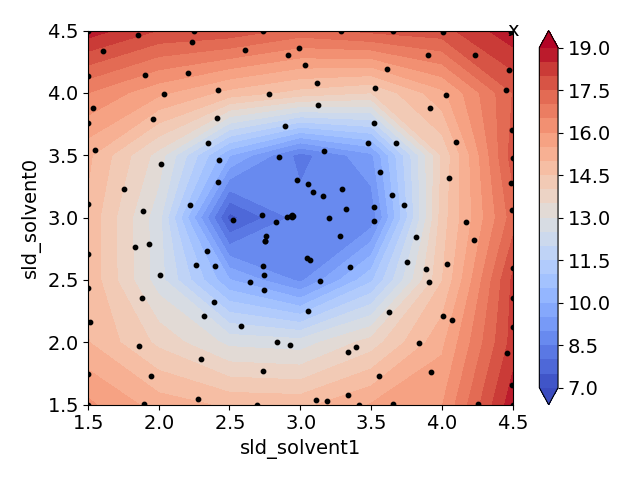

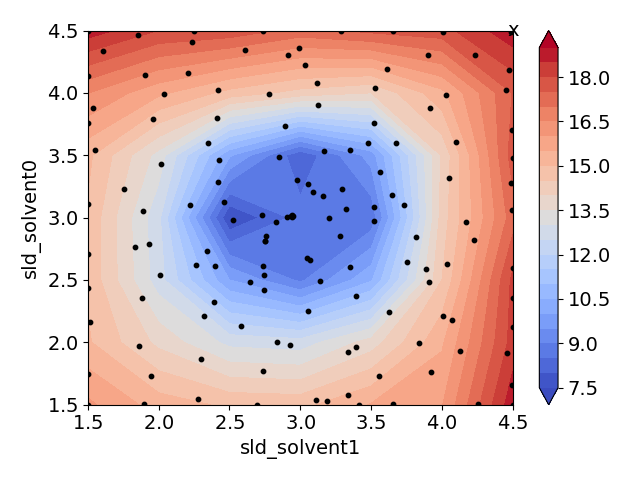

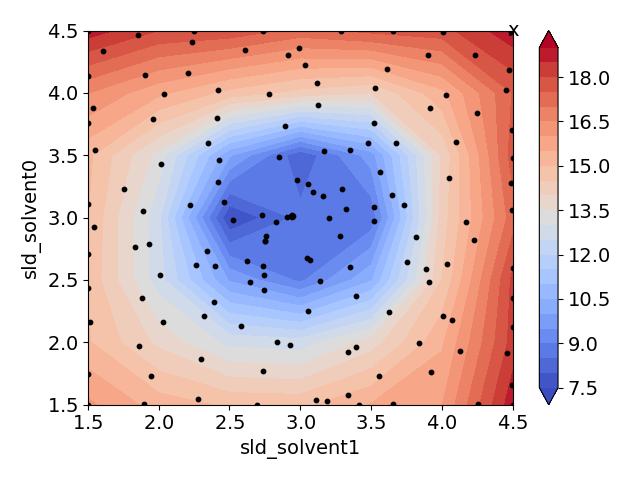

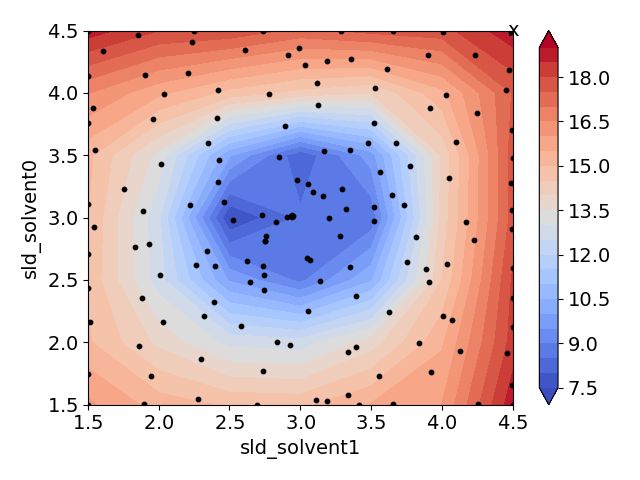

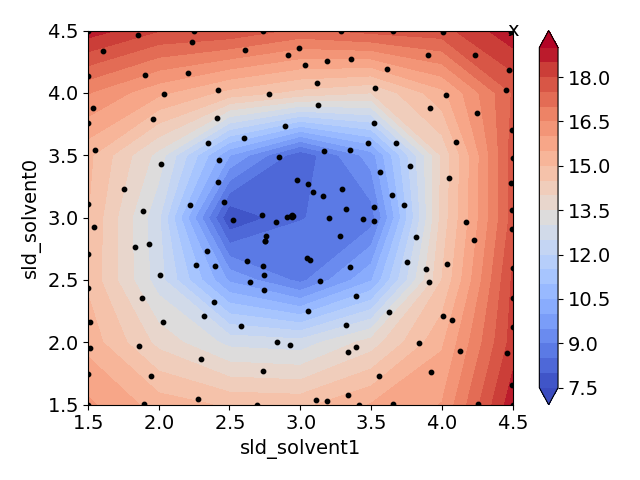

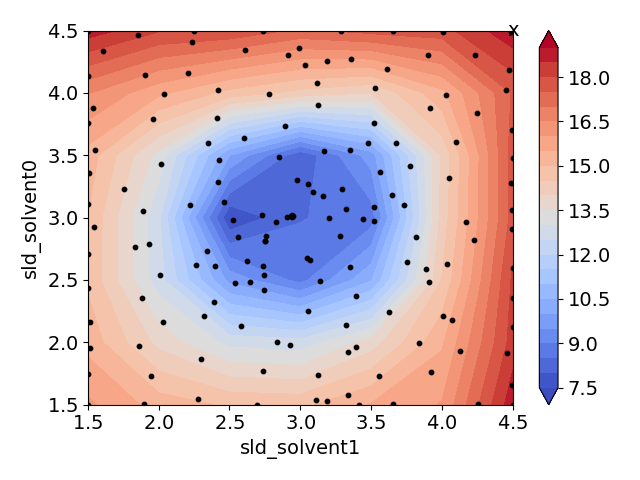

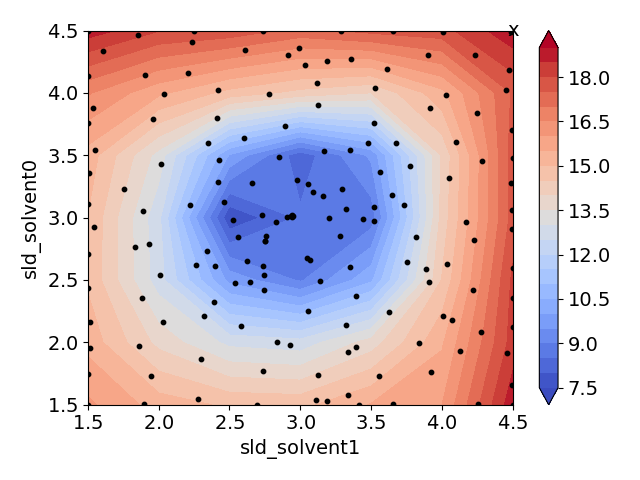

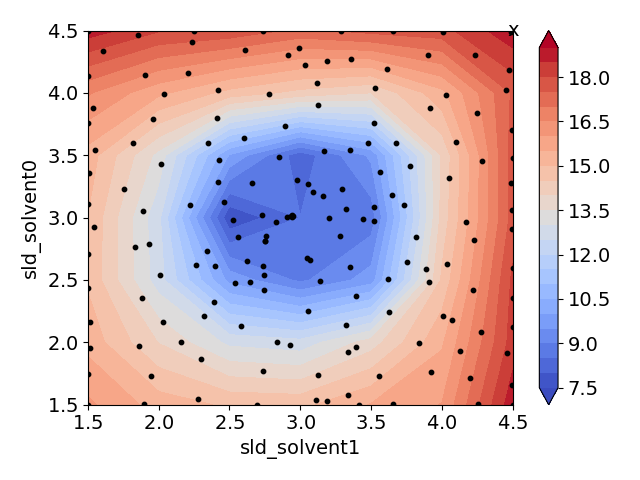

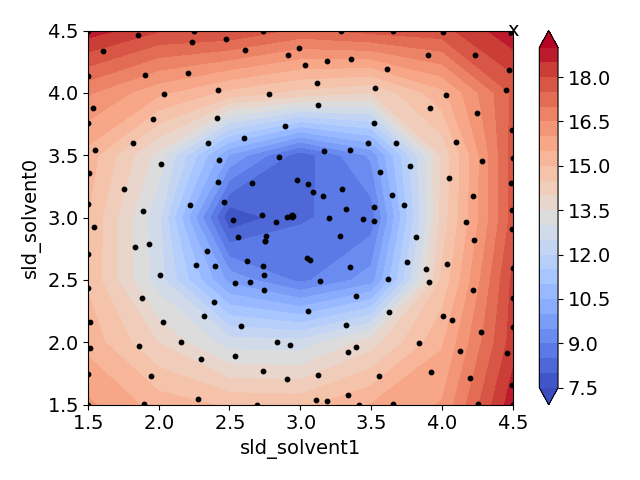

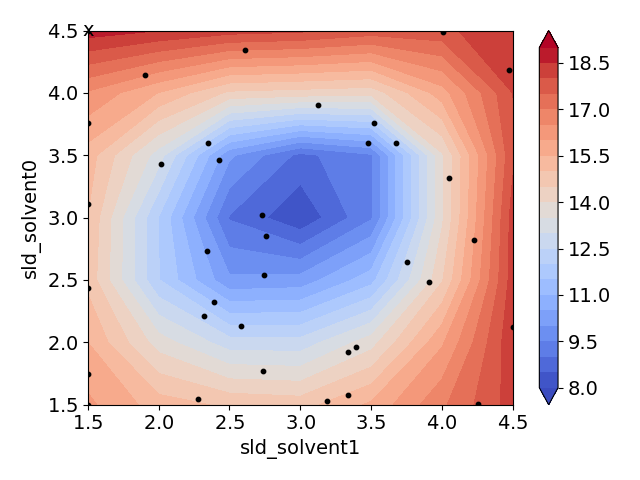

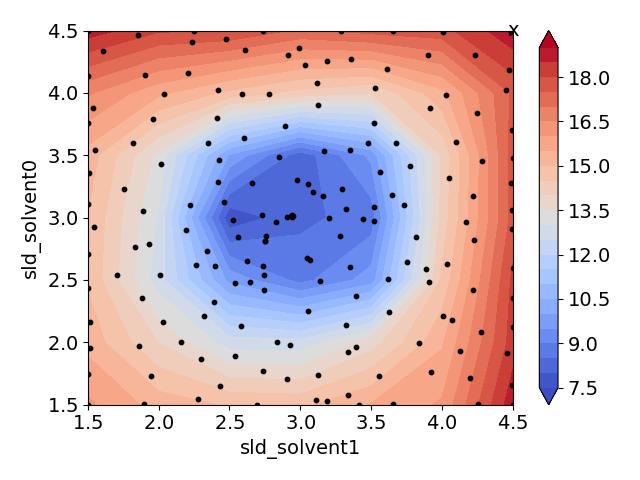

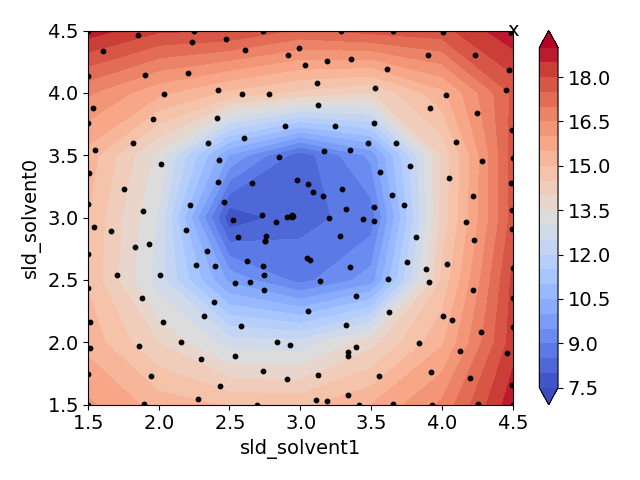

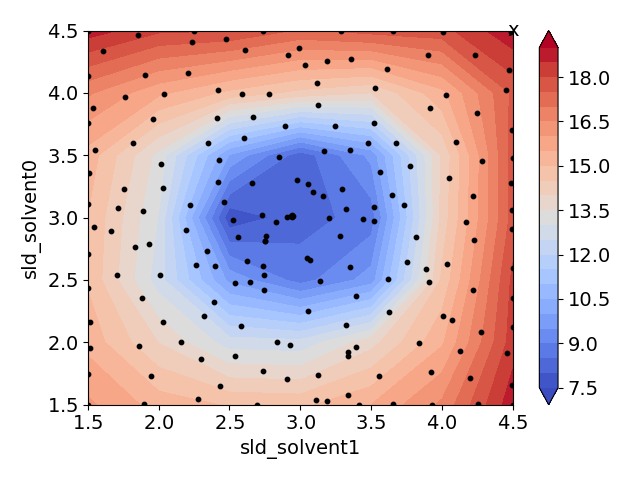

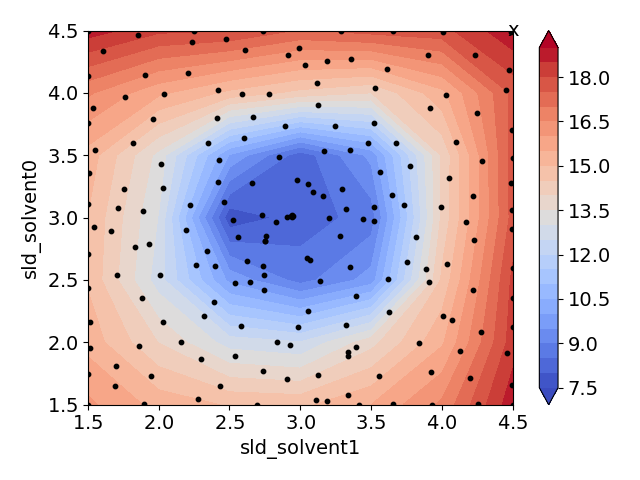

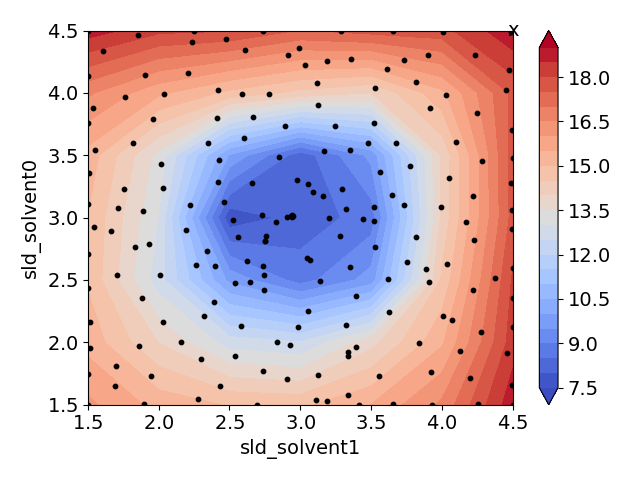

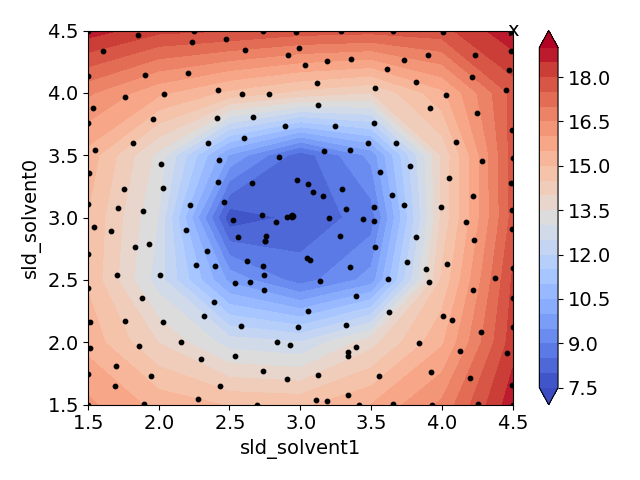

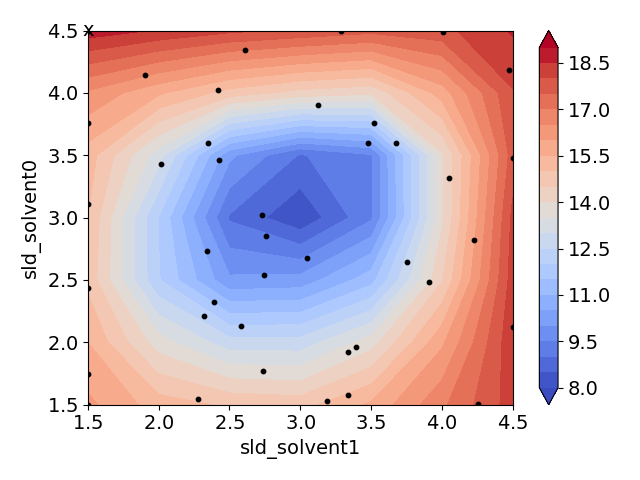

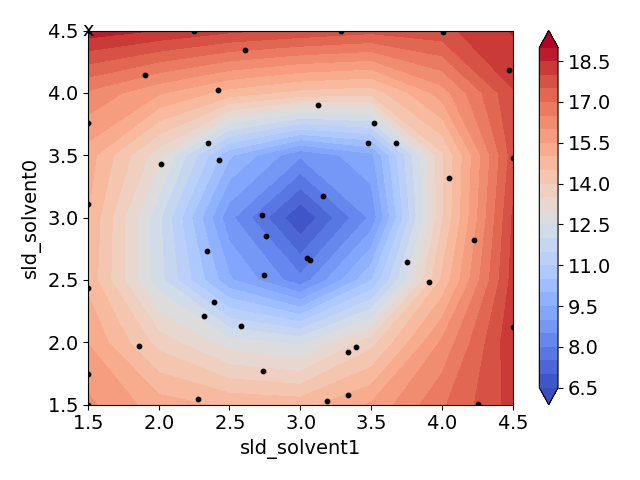

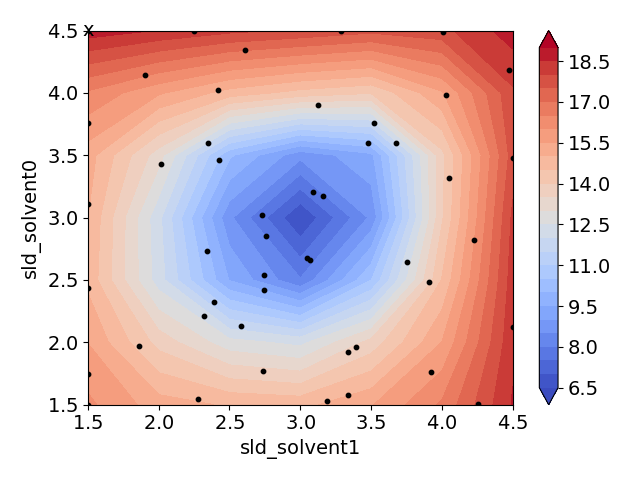

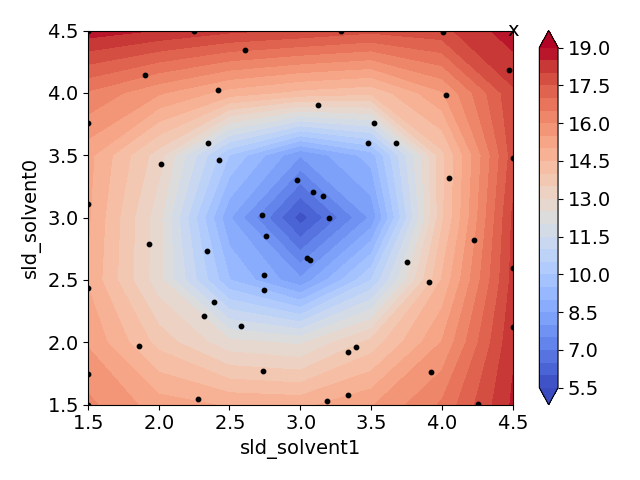

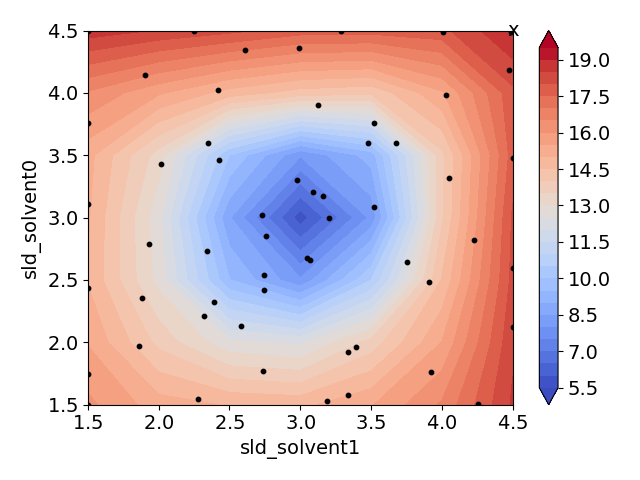

In [15]:
from IPython.display import Image, display
import glob
from os import path
for file in glob.glob(path.join(setupdir, 'plots', "*.png")):
    display(Image(filename=file))

In [16]:
import imageio.v2 as iio
import os
w = iio.get_writer(os.path.join(setupdir, 'plots','gpcam_timelapse.mp4'), format='FFMPEG', mode='I', fps=1)
i = 0
while os.path.isfile(os.path.join(setupdir, 'plots', 'prediction_gpcam'+str(i)+'.png')):
    im = iio.imread(os.path.join(setupdir, 'plots', 'prediction_gpcam'+str(i)+'.png'))
    w.append_data(im)
    i += 1
w.close()